In [47]:
import lightning as L
import numpy as np
import torch
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.datasets.gradient_dataset import GradientDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.setr import SETR_PUP
from minerva.models.nets.EfficientUnet import EfficientUnet
from minerva.transforms.transform import _Transform, TransformPipeline
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from matplotlib import pyplot as plt
from pathlib import Path
import os
import importlib

In [48]:
train_path = "/workspace/f3/images"
annotation_path = "/workspace/f3/annotations"

In [49]:
class Padding(_Transform):
    def __init__(self, target_h_size: int, target_w_size: int):
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        pad_h = max(0, self.target_h_size - h)
        pad_w = max(0, self.target_w_size - w)
        if len(x.shape) == 2:
            padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
            padded = np.expand_dims(padded, axis=2)
            padded = torch.from_numpy(padded).float()
        else:
            padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            padded = torch.from_numpy(padded).float()

        padded = np.transpose(padded, (2, 0, 1))
        return padded


In [50]:
class SqueezeTarget(_Transform):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        if x.shape[0] == 1:
            return np.squeeze(x, axis=0).to(dtype=torch.long)
        else: return x

In [51]:
transform = TransformPipeline([
    Padding(256, 704),
    # SqueezeTarget()
])

In [52]:

train_img_reader = TiffReader(train_path + "/train")
train_label_reader = PNGReader(annotation_path + "/train")
train_dataset = GradientDataset(
    readers=[train_img_reader, train_label_reader],
    transforms=transform,
)

data = train_dataset[500]
data[0], data[1]

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 3.2633e-04,  4.0897e-03,  1.0681e-02,  ..., -4.4022e-02,
           -4.4557e-02, -4.9037e-02],
          [-4.0898e-02, -2.1146e-02,  1.1977e-02,  ..., -2.6982e-01,
           -2.7179e-01, -2.8558e-01],
          ...,
          [-1.5310e-01, -1.2605e-01, -1.2557e-01,  ..., -5.8470e-02,
           -8.0378e-02, -1.1665e-01],
          [-1.5310e-01, -1.2605e-01, -1.2557e-01,  ..., -5.8470e-02,
           -8.0378e-02, -1.1665e-01],
          [-1.5310e-01, -1.2605e-01, -1.2557e-01,  ..., -5.8470e-02,
           -8.0378e-02, -1.1665e-01]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 3.9370e-03,  3.9370e-03,  3.9370e-03,  ...,  3.9370e-03,
            3.9370e-03,  3.9370e-03],
          [ 7.8740e-03,  7.8740e-03,  7.8740e-03,  ...,  7.8740e-03,
            7.8740e-03,  7.8740e-03],
          ...,
    

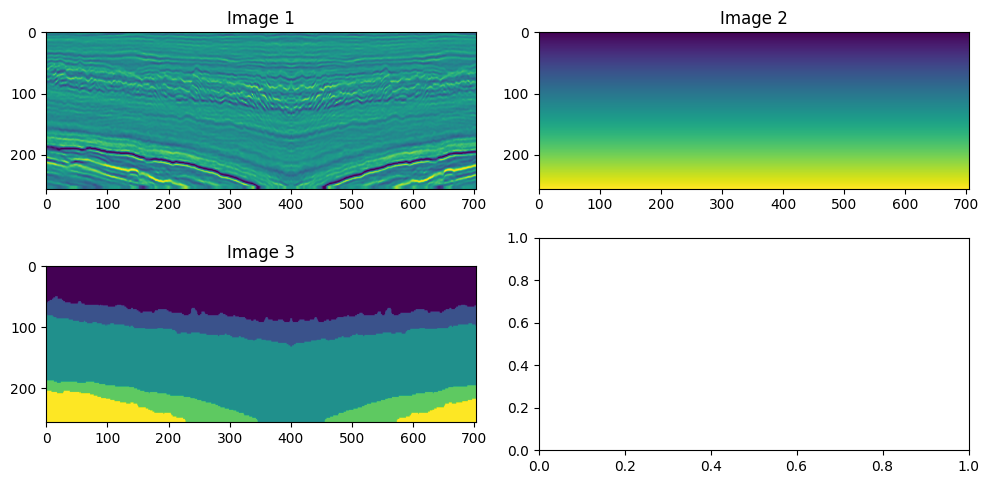

In [53]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Plot the first image
axs[0, 0].imshow(data[0][0])
axs[0, 0].set_title("Image 1")

# Plot the second image
axs[0, 1].imshow(data[0][1])
axs[0, 1].set_title("Image 2")

# Plot the third image
axs[1, 0].imshow(data[1])
axs[1, 0].set_title("Image 3")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [54]:
class F3DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        batch_size: int = 1,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")
            train_dataset = GradientDataset(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")
            val_dataset = GradientDataset(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")
            test_dataset = GradientDataset(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )


data_module = F3DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    transforms=transform,
    batch_size=16,
)

In [55]:
# importlib.reload(EfficientUnet)
model = EfficientUnet(
    n_channels=2,
    n_classes=6,
    train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

In [56]:
trainer = L.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=[0],
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | _EfficientUnet   | 2.3 M 
1 | fc       | Identity         | 0     
2 | loss_fn  | CrossEntropyLoss | 0     
----------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.181     Total estimated model params size (MB)


Log directory set to: /workspace/UnetReplicate/lightning_logs/version_27
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 1:   5%|▍         | 3/62 [00:03<01:06,  0.89it/s, v_num=27, val_loss=0.375, val_mIoU=0.645, train_loss=0.641, train_mIoU=0.572] Pipeline info saved at: /workspace/UnetReplicate/lightning_logs/version_27/run_2024-06-01-18-05-58a4fc9b2520644eb3859513d08808135a.yaml


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 400/400 [00:03<00:00, 121.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3835342526435852     │
│         test_mIoU         │    0.7154086828231812     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspace/UnetReplicate/lightning_logs/version_24/run_2024-06-01-17-43-10f6e07064c9a747b39d51cae2fb3d1c4f.yaml


[{'test_loss': 0.3835342526435852, 'test_mIoU': 0.7154086828231812}]

In [ ]:
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 400/400 [00:03<00:00, 117.56it/s]
Pipeline info saved at: /workspace/UnetReplicate/lightning_logs/version_24/run_2024-06-01-17-43-10f6e07064c9a747b39d51cae2fb3d1c4f.yaml


In [ ]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

In [ ]:
image = torch.argmax(preds[31], dim=1)

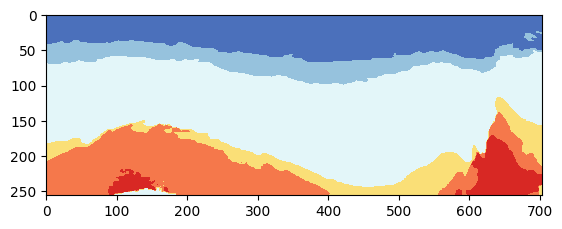

In [ ]:
plt.imshow(image.squeeze().numpy(), cmap=label_cmap)
plt.show()